In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
import seaborn as sns

In [51]:
#Read in player logs
hist_player_log_full = pd.read_csv('hist_player_log.csv')
#Read in player injury history
full_injury_data = pd.read_csv('full_injury_data_clean.csv', parse_dates=['Date'])
#Read in player info
hist_player_info = pd.read_csv('hist_player_info.csv', parse_dates=['BIRTHDATE'])

## Things to do:

- Eliminate duplicate injuries (eg. where an DTD injury leads to surgery) by merging the injury data to the gamelogs, to determine whether a game was played between injuries ☑
- Go back and fix the original injury data, with the above fix.☑

In [52]:
#We should treat injury rows on the same part of the body as the same injury - take the latter row and remove earlier.
#We need to create a function to incorporate this logic. We can use the player game log data to see whether the player
# played a game in between injuries - if they have, then we can regard the injury as new.
# full_injury_data[['Date', 'full_name_main']]
hist_player_log_slice = hist_player_log_full[['full_name', 'GAME_DATE']]
hist_player_log_slice['Date'] = hist_player_log_slice['GAME_DATE'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))
hist_player_log_slice['InjuryFlag'] = 0
hist_player_log_slice['GameFlag'] = 1
hist_player_log_slice[hist_player_log_slice['full_name']=='Kawhi Leonard'].tail()

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,full_name,GAME_DATE,Date,InjuryFlag,GameFlag
54393,Kawhi Leonard,"APR 30, 2016",2016-04-30,0,1
54394,Kawhi Leonard,"APR 24, 2016",2016-04-24,0,1
54395,Kawhi Leonard,"APR 22, 2016",2016-04-22,0,1
54396,Kawhi Leonard,"APR 19, 2016",2016-04-19,0,1
54397,Kawhi Leonard,"APR 17, 2016",2016-04-17,0,1


In [53]:
full_injury_data_slice = full_injury_data[['full_name_main', 'Date', 'injury_anat_partone']]
full_injury_data_slice['Date'] = pd.to_datetime(full_injury_data_slice['Date'])
full_injury_data_slice['InjuryFlag'] = 1
full_injury_data_slice['GameFlag'] = 0
full_injury_data_slice[full_injury_data_slice['full_name_main']=='Kawhi Leonard'].head(12)

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,full_name_main,Date,injury_anat_partone,InjuryFlag,GameFlag
192,Kawhi Leonard,2014-12-17,hand,1,0
1164,Kawhi Leonard,2016-02-18,tightness,1,0
1323,Kawhi Leonard,2016-03-23,quadriceps,1,0
1418,Kawhi Leonard,2016-04-08,rest,1,0
1483,Kawhi Leonard,2016-04-13,rest,1,0
1840,Kawhi Leonard,2016-12-28,gastroenteritis,1,0
1962,Kawhi Leonard,2017-01-23,hand,1,0
2033,Kawhi Leonard,2017-02-06,quadriceps,1,0
2127,Kawhi Leonard,2017-03-10,concussion,1,0
2264,Kawhi Leonard,2017-04-07,rest,1,0


In [54]:
full_injury_game_slice = pd.concat([full_injury_data_slice.rename(columns={'full_name_main':'full_name'}),
                                    hist_player_log_slice[['full_name', 'Date', 'InjuryFlag','GameFlag']]],ignore_index=True)
full_injury_game_slice = full_injury_game_slice.sort_values(['full_name', 'Date'], ascending=[1,1])
full_injury_game_slice['injury_anat_partone'] = full_injury_game_slice['injury_anat_partone'].fillna('')
full_injury_game_slice = full_injury_game_slice.groupby(['full_name', 'Date']).agg({'GameFlag' : 'sum',
                                                          'InjuryFlag' : 'sum',
                                                          'injury_anat_partone' : 'sum'}).reset_index()
full_injury_game_slice[(full_injury_game_slice['full_name']=='Kawhi Leonard') & (full_injury_game_slice['Date']>='2017-05-13')].head()

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,full_name,Date,GameFlag,InjuryFlag,injury_anat_partone
52284,Kawhi Leonard,2017-05-14,1,1,ankle
52285,Kawhi Leonard,2017-05-22,0,1,ankle
52286,Kawhi Leonard,2017-09-30,0,1,quadriceps
52287,Kawhi Leonard,2017-12-12,1,0,
52288,Kawhi Leonard,2017-12-15,1,0,


In [55]:

#Identify the instances where the injury turns up twice in a row (without game in between) for a player
full_injury_game_slice['future_inj'] = full_injury_game_slice['InjuryFlag'].shift(-1)
full_injury_game_slice['future_inj_anat'] = full_injury_game_slice['injury_anat_partone'].shift(-1)
full_injury_game_slice['future_full_name'] = full_injury_game_slice['full_name'].shift(-1)
injury_dupes = full_injury_game_slice[((full_injury_game_slice['future_inj'] == full_injury_game_slice['InjuryFlag']) 
     & (full_injury_game_slice['future_inj_anat'] == full_injury_game_slice['injury_anat_partone'])
     & (full_injury_game_slice['full_name'] == full_injury_game_slice['future_full_name'])
     &(full_injury_game_slice['future_inj_anat'] != '') )]

#Merge and eliminate
full_injury_data_final = full_injury_data.merge(injury_dupes[['full_name','Date']].drop_duplicates(), left_on=['full_name_main','Date']
                                , right_on=['full_name','Date'], 
                   how='left', indicator=True)
full_injury_data_final = full_injury_data_final[full_injury_data_final['_merge']=='left_only']

full_injury_data_final[full_injury_data_final['full_name_main']=='Kawhi Leonard'].head()

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class,...,injury_position_lower,injury_surgery,injury_strained,injury_sprained,injury_sore,injury_details,injury_anat,injury_anat_partone,full_name,_merge
192,2014-12-17,Spurs,,Kawhi Leonard,bruised right hand (DTD),Kawhi Leonard,Kawhi Leonard,NaN,NaN,DTD,...,0,0,0,0,0,bruised hand,hand,hand,NaN,left_only
1164,2016-02-18,Spurs,,Kawhi Leonard,tightness in left calf (DTD),Kawhi Leonard,Kawhi Leonard,NaN,NaN,DTD,...,0,0,0,0,0,tightness calf,tightness calf,tightness,NaN,left_only
1323,2016-03-23,Spurs,,Kawhi Leonard,bruised right quadriceps (DTD),Kawhi Leonard,Kawhi Leonard,NaN,NaN,DTD,...,0,0,0,0,0,bruised quadriceps,quadriceps,quadriceps,NaN,left_only
1418,2016-04-08,Spurs,,Kawhi Leonard,rest (DTD),Kawhi Leonard,Kawhi Leonard,NaN,NaN,DTD,...,0,0,0,0,0,rest,rest,rest,NaN,left_only
1483,2016-04-13,Spurs,,Kawhi Leonard,rest (DTD),Kawhi Leonard,Kawhi Leonard,NaN,NaN,DTD,...,0,0,0,0,0,rest,rest,rest,NaN,left_only


In [56]:
full_injury_data_final.to_csv('full_injury_data_final.csv', index=False)

## EDA
- injury type and frequency

In [57]:
full_injury_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 4 to 3459
Data columns (total 24 columns):
Date                     3142 non-null datetime64[ns]
Team                     3142 non-null object
Acquired                 3142 non-null object
Relinquished             3142 non-null object
Notes                    3142 non-null object
full_name_raw            3142 non-null object
full_name_main           3142 non-null object
full_name_alt            152 non-null object
full_name_brack          72 non-null object
injury_class             3100 non-null object
notes_clean              3140 non-null object
injury_position_left     3142 non-null int64
injury_position_right    3142 non-null int64
injury_position_upper    3142 non-null int64
injury_position_lower    3142 non-null int64
injury_surgery           3142 non-null int64
injury_strained          3142 non-null int64
injury_sprained          3142 non-null int64
injury_sore              3142 non-null int64
injury_details        

In [58]:
#There is not really a difference in what side an injury occurs on overall.
injury_loc_freq = full_injury_data_final \
    .agg({'injury_position_left' : 'sum', 'injury_position_right' : 'sum'}) 
injury_loc_freq

injury_position_left     971
injury_position_right    934
dtype: int64

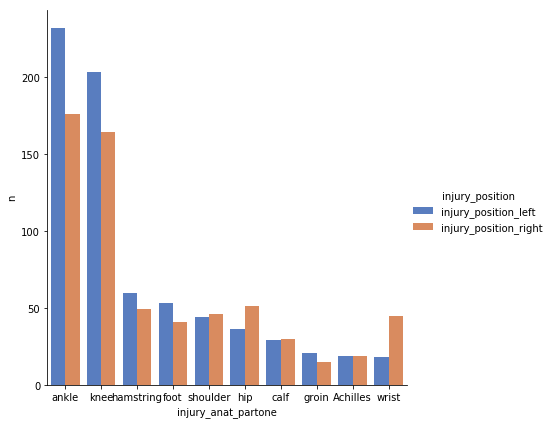

In [59]:
#Left ankles and knees are injured more often than right. Why?
#Right wrists are injured more often than left. Maybe players that are right handed can play through a left wrist injury.
injury_loc_freq = full_injury_data_final \
    .groupby(['injury_anat_partone']) \
    .agg({'injury_position_left' : 'sum', 'injury_position_right' : 'sum'}).reset_index() \
    .sort_values('injury_position_left', ascending=False).head(10)
injury_loc_freq = pd.melt(injury_loc_freq, id_vars=['injury_anat_partone']
        , value_vars=['injury_position_left', 'injury_position_right']
        , var_name='injury_position', value_name='n')
sns.catplot(x="injury_anat_partone", y="n", hue="injury_position", data=injury_loc_freq,
                height=6, kind="bar", palette="muted")
# injury_loc_freq

In [60]:
#Bring in height / weight / age of player to measure these effects
full_injury_data_final = full_injury_data_final.merge(hist_player_info, left_on='full_name_main',right_on='full_name',how='inner')
full_injury_data_final['Age'] = (full_injury_data_final['Date'] - full_injury_data_final['BIRTHDATE']).dt.days

In [61]:
injury_pairplot_df = full_injury_data_final[
    ['POSITION', 'HEIGHT','WEIGHT','Age','injury_class']][full_injury_data_final['injury_class'].isin(['DTD', 'out for season', 'out indefinitely'])]
dummies = pd.get_dummies(injury_pairplot_df['injury_class'])
injury_pairplot_df = pd.concat([injury_pairplot_df, dummies], axis=1)

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


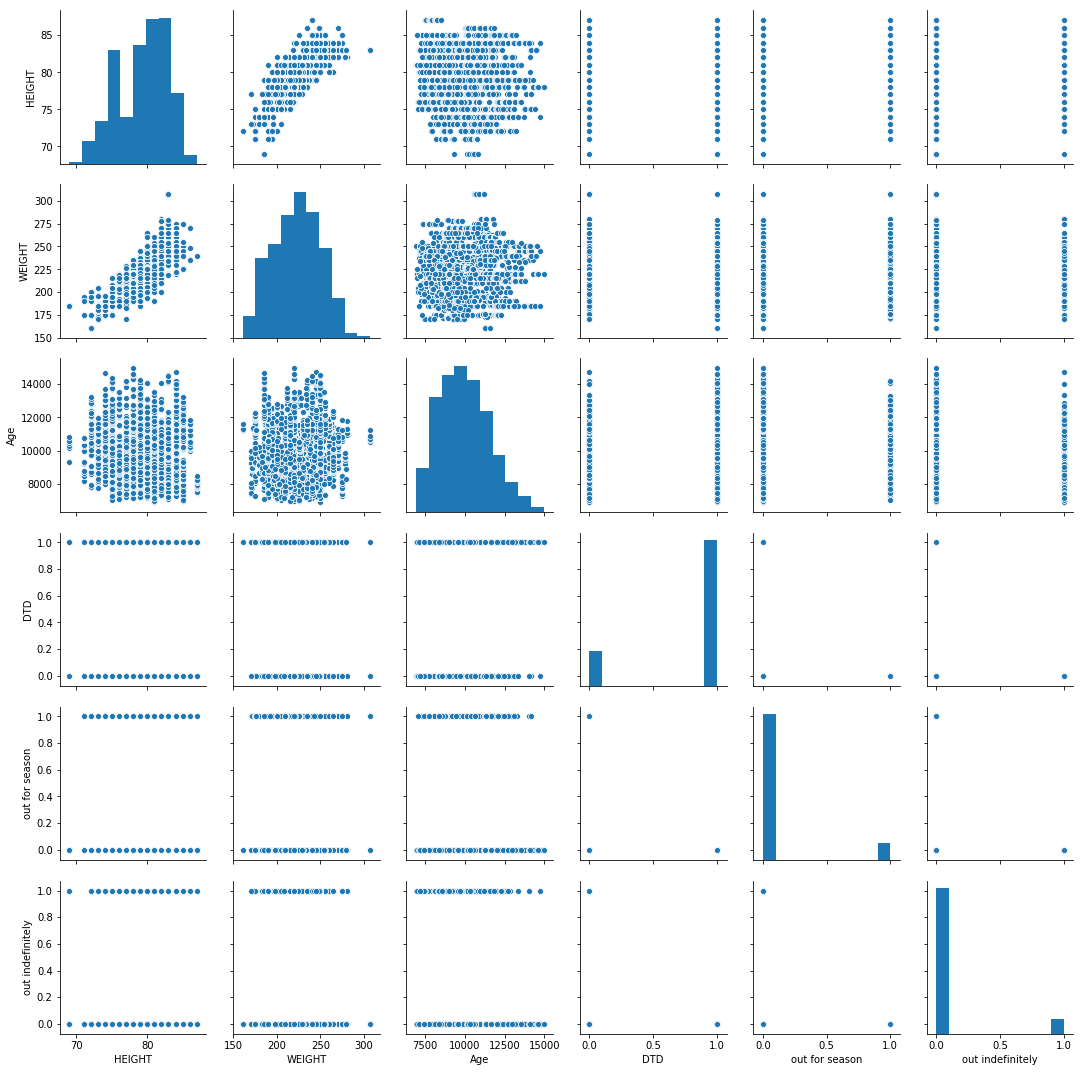

In [62]:
sns.pairplot(injury_pairplot_df)

In [63]:
full_injury_data_final.head()

,Date,Team,Acquired,Relinquished,Notes,full_name_raw,full_name_main,full_name_alt,full_name_brack,injury_class,...,full_name_x,_merge,PERSON_ID,BIRTHDATE,FROM_YEAR,HEIGHT,WEIGHT,POSITION,full_name_y,Age
0,2014-05-03,Warriors,,Andrew Bogut,fractured right rib (DNP),Andrew Bogut,Andrew Bogut,NaN,NaN,DNP,...,NaN,left_only,101106,1984-11-28,2005,NaN,NaN,NaN,Andrew Bogut,10748
1,2015-01-27,Warriors,,Andrew Bogut,flu (DTD),Andrew Bogut,Andrew Bogut,NaN,NaN,DTD,...,NaN,left_only,101106,1984-11-28,2005,NaN,NaN,NaN,Andrew Bogut,11017
2,2015-10-28,Warriors,,Andrew Bogut,concussion (DTD),Andrew Bogut,Andrew Bogut,NaN,NaN,DTD,...,NaN,left_only,101106,1984-11-28,2005,NaN,NaN,NaN,Andrew Bogut,11291
3,2015-12-05,Warriors,,Andrew Bogut,back spasms (DTD),Andrew Bogut,Andrew Bogut,NaN,NaN,DTD,...,NaN,left_only,101106,1984-11-28,2005,NaN,NaN,NaN,Andrew Bogut,11329
4,2016-02-20,Warriors,,Andrew Bogut,strained right Achilles (DTD),Andrew Bogut,Andrew Bogut,NaN,NaN,DTD,...,NaN,left_only,101106,1984-11-28,2005,NaN,NaN,NaN,Andrew Bogut,11406
